<a href="https://colab.research.google.com/github/alampa1/lamguara/blob/main/ip_address.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2025 Google LLC.

# Gemini API: Getting started with Gemini models

<a target="_blank" href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/Get_started.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" height=30/></a>

---
> **Gemini 3 Pro/Flash**: If you are only interested in the new [Gemini 3 models](https://ai.google.dev/gemini-api/docs/gemini-3) new capabilities ([thinking levels](#thinking_level), [media resolution](#media_resolution) and [thoughts signatures](#thoughts_signature), jump directly to the [dedicated section](#gemini3) at the end of this notebook.

---


In [ ]:
import socket  # The standard library for network connections
from datetime import datetime

def port_scanner(target_ip):
    # List of common ports to scan
    # 22: SSH, 80: HTTP, 443: HTTPS, 53: DNS, 21: FTP
    common_ports = [21, 22, 23, 25, 53, 80, 110, 443]

    print("-" * 50)
    print(f"Scanning Target: {target_ip}")
    print(f"Scanning started at: {str(datetime.now())}")
    print("-" * 50)

    try:
        for port in common_ports:
            # Create a socket object
            # AF_INET = IPv4, SOCK_STREAM = TCP
            s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)

            # Set a timeout so the script doesn't hang on closed ports
            # 1 second is usually enough for local networks
            socket.setdefaulttimeout(1)

            # .connect_ex returns an error indicator (0 if successful)
            result = s.connect_ex((target_ip, port))

            if result == 0:
                print(f"Port {port}: OPEN")
            else:
                # Optional: print(f"Port {port}: CLOSED")
                pass

            # Always close the connection
            s.close()

    except KeyboardInterrupt:
        print("\n Exiting program...")
    except socket.gaierror:
        print("\n Hostname Could Not Be Resolved.")
    except socket.error:
        print("\n Server not responding.")

# --- EXECUTION ---
# For Google Colab/Home use:
# Replace with your router IP (often 192.168.1.1) or 'google.com'
target = input("Enter the IP address or Hostname to scan: ")
port_scanner(target)

Enter the IP address or Hostname to scan: 10.10.10.183
--------------------------------------------------
Scanning Target: 10.10.10.183
Scanning started at: 2026-01-20 23:04:16.014671
--------------------------------------------------


The **[Google Gen AI SDK](https://github.com/googleapis/python-genai)** provides a unified interface to [Gemini models](https://ai.google.dev/gemini-api/docs/models) through both the [Gemini Developer API](https://ai.google.dev/gemini-api/docs) and the Gemini API on [Vertex AI](https://cloud.google.com/vertex-ai/generative-ai/docs/overview). With a few exceptions, code that runs on one platform will run on both. This notebook uses the Developer API.

This notebook will walk you through:

* [Installing and setting-up](#setup) the Google GenAI SDK
* [Text](#text_prompt) and [multimodal](#multimodal_prompt) prompting
* Setting [system instructions](#system_instructions)
* Control the [thinking](#thinking) process
* Counting [tokens](#count_tokens)
* Configuring [safety filters](#safety_filters)
* Initiating a [multi-turn chat](#chat)
* Generating a [content stream](#stream) and sending [asynchronous](#async) requests
* [Controlling generated output](#json)
* Using [function calling](#function_calling)
* Grounding your requests using [file uploads](#file_api), [Google Search](#search_grounding), [Google Maps](#maps), [Youtube](#youtube_link) or by add [URLs](#url_context) to you prompt
* Using [context caching](#caching)
* Generating [text embeddings](#embeddings)

More details about the SDK on the [documentation](https://ai.google.dev/gemini-api/docs/sdks).

Feature-specific models have their own dedicated guides:
* Podcast and speech generation using [Gemini TTS ![image](https://storage.googleapis.com/generativeai-downloads/images/colab_icon16.png)](./Get_started_TTS.ipynb),
* Live interaction with [Gemini Live ![image](https://storage.googleapis.com/generativeai-downloads/images/colab_icon16.png)](./Get_started_LiveAPI.ipynb),
* Image generation using [Imagen ![image](https://storage.googleapis.com/generativeai-downloads/images/colab_icon16.png)](./Get_started_imagen.ipynb),
* Video generation using [Veo ![image](https://storage.googleapis.com/generativeai-downloads/images/colab_icon16.png)](./Get_started_Veo.ipynb),
* Music generation using [Lyria RealTime ![image](https://storage.googleapis.com/generativeai-downloads/images/colab_icon16.png)](./Get_started_LyriaRealTime.ipynb).

<a name="setup"></a>
## Setup

### Install SDK

Install the SDK from [PyPI](https://github.com/googleapis/python-genai). It's recommended to always use the latest version.

In [ ]:
%pip install -U -q 'google-genai>=1.51.0' # 1.51 is needed for Gemini 3 pro thinking levels support

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.5/260.5 kB 8.7 MB/s eta 0:00:00


### Setup your API key

To run the following cell, your API key must be stored it in a Colab Secret named `GEMINI_API_KEY`. If you don't already have an API key or you aren't sure how to create a Colab Secret, see [Authentication ![image](https://storage.googleapis.com/generativeai-downloads/images/colab_icon16.png)](../quickstarts/Authentication.ipynb) for an example.

In [ ]:
from google.colab import userdata

GEMINI_API_KEY = userdata.get('GEMINI_API_KEY')

### Initialize SDK client

With the new SDK, now you only need to initialize a client with you API key (or OAuth if using [Vertex AI](https://cloud.google.com/vertex-ai)). The model is now set in each call.

In [ ]:
from google import genai
from google.genai import types

client = genai.Client(api_key=GEMINI_API_KEY)

### Choose a model

Select the model you want to use in this guide. You can either select one from the list or enter a model name manually. Keep in mind that some models, such as the 2.5 ones are thinking models and thus take slightly more time to respond. For more details, you can see [thinking notebook ![image](https://storage.googleapis.com/generativeai-downloads/images/colab_icon16.png)](./Get_started_thinking.ipynb) to learn how to control the thinking.

Feel free to select [Gemini 3 Pro](https://ai.google.dev/gemini-api/docs/models#gemini-3-pro) if you want to try our newest model, but keep in mind that it has no free tier.

For a full overview of all Gemini models, check the [documentation](https://ai.google.dev/gemini-api/docs/models/gemini).

In [ ]:
MODEL_ID = "gemini-2.5-flash" # @param ["gemini-2.5-flash-lite", "gemini-2.5-flash", "gemini-2.5-pro", "gemini-3-flash-preview", "gemini-3-pro-preview"] {"allow-input":true, isTemplate: true}

<a name="text_prompt"></a>
## Send text prompts

Use the `generate_content` method to generate responses to your prompts. You can pass text directly to `generate_content` and use the `.text` property to get the text content of the response. Note that the `.text` field will work when there's only one part in the output.

In [ ]:
from IPython.display import Markdown

response = client.models.generate_content(
    model=MODEL_ID,
    contents="What's the largest planet in our solar system?"
)

display(Markdown(response.text))

The largest planet in our solar system is **Jupiter**.

It's a gas giant and is more than twice as massive as all the other planets combined!

<a name="system_instructions"></a>
## Add system instructions

You can also add system instructions to give the model direction on how to respond and which persona it should use. This is especially useful for mixture-of-experts models like the the pro models.

In [ ]:
system_instruction = "You are a pirate and are explaining things to 5 years old kids."

response = client.models.generate_content(
    model=MODEL_ID,
    contents="What's the largest planet in our solar system?",
    config=types.GenerateContentConfig(
        system_instruction=system_instruction,
    )
)

display(Markdown(response.text))


Ahoy there, me hearties! Gather 'round, gather 'round, and let old Cap'n tell ye a grand secret of the skies!

Ye wanna know which planet is the biggest, eh? The most enormous, the most ginormous, the proper behemoth of them all?

Well, batten down the hatches and listen close! It be the mighty **JUPITER**!

Shiver me timbers, that planet is a true giant! Imagine yer very own Earth, the one we're standin' on right now... well, ye could fit *over a thousand* of those little Earths right inside Jupiter! It's that big!

It's like the biggest, swirliest marble ye ever did see, made of gas and storms, with a giant red eye always lookin' out into space! A real king of the planets, it is!

What do ye think of that, eh? A mighty, mighty world, Jupiter is!

<a name="count_tokens"></a>
## Count tokens

Tokens are the basic inputs to the Gemini models. You can use the `count_tokens` method to calculate the number of input tokens before sending a request to the Gemini API.

In [ ]:
response = client.models.count_tokens(
    model=MODEL_ID,
    contents="What's the highest mountain in Africa?",
)

print(f"This prompt was worth {response.total_tokens} tokens.")

This prompt was worth 10 tokens.


<a name="parameters"></a>
## Configure model parameters

You can include parameter values in each call that you send to a model to control how the model generates a response.

Learn more about [experimenting with parameter values](https://ai.google.dev/gemini-api/docs/prompting-strategies#model-parameters) in the documentation.

In [ ]:
response = client.models.generate_content(
    model=MODEL_ID,
    contents="Tell me how the internet works, but pretend I'm a puppy who only understands squeaky toys.",
    config=types.GenerateContentConfig(
        temperature=0.4, # Temperature of 1 is strongly recommended for Gemini 3 Pro
        top_p=0.95,
        top_k=20,
        candidate_count=1,
        seed=5,
        stop_sequences=["STOP!"],
        presence_penalty=0.0,
        frequency_penalty=0.0,
    )
)

display(Markdown(response.text))

*Woof!* Sit! Stay! Who’s a good boy? You are! Listen close. Ears up!

Okay, imagine the whole world is one giant backyard.

**1. The Magic Window (Your Computer)**
You are sitting in front of the Magic Window. You see a picture of a ball. You want the ball. You tap the Magic Window with your paw. That tap is a **SQUEAK**.

**2. The Invisible Leash (Wi-Fi)**
When you Squeak, the sound doesn't stay here. It runs very fast! It runs along the Invisible Leash. *Zoom!* Like when you get the zoomies!

**3. The Router (The Fetch Master)**
The Squeak runs to a little blinking box in the corner. That box is the Fetch Master. The Fetch Master catches your Squeak and throws it *really far* out of the house. *Go long!*

**4. The Wires (The Tunnels)**
Your Squeak runs through tunnels under the ground. It runs past the mailman (grrr!), past the squirrels, all the way to a giant building far away.

**5. The Server (The Giant Toy Box)**
The giant building is the Giant Toy Box. It has *all* the squeaky toys in the world.
Your Squeak arrives and barks, "I WANT THE RED BALL!"
The Giant Toy Box hears you. It finds the Red Ball.

**6. Packets (Chewing the Toy)**
But wait! The Red Ball is too big to fit through the tunnels!
So, the Giant Toy Box chews the ball into tiny, tiny pieces. *Chomp chomp chomp.*
Don't worry! It’s okay!
It throws all the tiny chewed pieces back into the tunnels. *Fetch!*

**7. Reassembly (The Miracle)**
The tiny pieces run back past the squirrels, past the mailman, through the Fetch Master box, and onto your Magic Window.
Your Magic Window catches all the tiny pieces and—*SQUEAK!*—glues them back together instantly!

Now the Red Ball is on your screen.

**SQUEAK SQUEAK!** Good internet! Good boy!

<a name="thinking"></a>
## Control the thinking process

All models since the 2.5 generation are thinking models, which means that they are first analysing your request, strategizing about how to answer and only afterwards starting to answer you. This is very useful for complex requests but at the cost of some latency.

Check the [dedicated guide ![image](https://storage.googleapis.com/generativeai-downloads/images/colab_icon16.png)](./Get_started_thinking.ipynb) for more details.

### Check the thought process

By adding the `include_thoughts=True` option in the config, you can check the though proces of the model.

In [ ]:
prompt = "A man moves his car to an hotel and tells the owner he’s bankrupt. Why?"

response = client.models.generate_content(
  model=MODEL_ID,
  contents=prompt,
  config=types.GenerateContentConfig(
    thinking_config=types.ThinkingConfig(
      include_thoughts=True
    )
  )
)

for part in response.parts:
  if not part.text:
    continue
  if part.thought:
    display(Markdown("### Thought summary:"))
    display(Markdown(part.text))
    print()
  else:
    display(Markdown("### Answer:"))
    display(Markdown(part.text))
    print()

print(f"We used {response.usage_metadata.thoughts_token_count} tokens for the thinking phase and {response.usage_metadata.prompt_token_count} for the output.")

### Thought summary:

**Unraveling the Riddle: A Monopoly-Focused Thought Process**

Alright, let's break this down. A man moves a car to a hotel and then declares bankruptcy. My initial instinct is to look beyond the literal. Is this some insurance scam? No, that's not it. I need to think outside the box, maybe a game scenario? The car and hotel seem oddly specific… Wait a minute! "Car," "Hotel," "Bankrupt"... *Monopoly*! That has to be it.

In *Monopoly*, you move your car token around the board and end up paying rent if you land on someone else's property, especially if it's got a hotel. This man is obviously playing as the car token, lands on a hotel property owned by someone else, and the rent is too steep, bam, bankruptcy!

The riddle is playing on our literal interpretation. The key is recognizing the symbolism. It's a classic lateral thinking puzzle. Moving the car represents landing on a hotel property, the owner is the opponent, and bankruptcy is the consequence of not being able to pay the rent. Simple enough. It is **Monopoly**. That's the answer.




### Answer:

He is playing **Monopoly**.

The man is playing as the racecar token. He landed on a property owned by the other player (the "owner") that had a hotel on it, and the rent was high enough to bankrupt him.


We used 575 tokens for the thinking phase and 20 for the output.


### Disable thinking

On flash and flash-lite models, you can disable the thinking by setting its `thinking_budget` to 0.

In [ ]:
if "-pro" not in MODEL_ID:
  response = client.models.generate_content(
    model=MODEL_ID,
    contents="Quicky tell me a joke about unicorns.",
    config=types.GenerateContentConfig(
      thinking_config=types.ThinkingConfig(
        thinking_budget=0
      )
    )
  )

  display(Markdown(response.text))

Why did the unicorn run across the road?

To get to the other rainbow!

Inversely, you can also use `thinking_budget` to set it even higher (up to 24576 tokens).

For Gemini 3, please check the [dedicated section](#thinking_level) at the end of this guide.

<a name="multimodal_prompt"></a>
## Send multimodal prompts

Use Gemini model, a multimodal model that supports multimodal prompts. You can include text, [PDF documents ![image](https://storage.googleapis.com/generativeai-downloads/images/colab_icon16.png)](../quickstarts/PDF_Files.ipynb), images, [audio ![image](https://storage.googleapis.com/generativeai-downloads/images/colab_icon16.png)](../quickstarts/Audio.ipynb) and [videos ![image](https://storage.googleapis.com/generativeai-downloads/images/colab_icon16.png)](../quickstarts/Video.ipynb) in your prompt requests and get text or code responses. Check the [File API](#file_api) section below for more examples.

In this first example, you'll download an image from a specified URL, save it as a byte stream and then write those bytes to a local file named `jetpack.png`.

In [ ]:
import requests
import pathlib
from PIL import Image

IMG = "https://storage.googleapis.com/generativeai-downloads/data/jetpack.png" # @param {type: "string"}

img_bytes = requests.get(IMG).content

img_path = pathlib.Path('jetpack.png')
img_path.write_bytes(img_bytes)

1567837

Now send the image, and ask Gemini to generate a short blog post based on it.

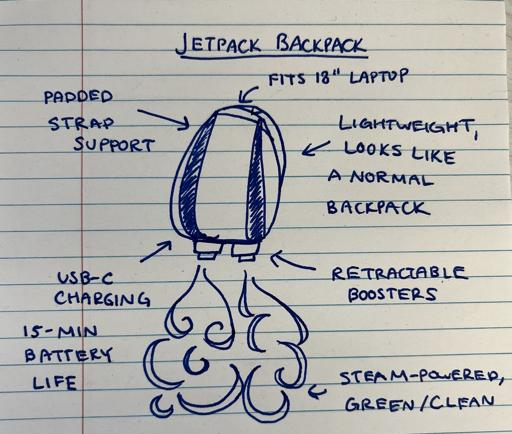

**Title: Beat the Traffic in Style: Introducing the Jetpack Backpack Concept**

We’ve all been there. You’re five minutes late, the train is delayed, or the highway is a parking lot, and you find yourself wishing you could just *lift off* and fly over the chaos.

Well, it looks like the solution might be sitting on a notepad right now.

We recently stumbled upon a concept sketch for what might be the greatest invention for the modern commuter: **The Jetpack Backpack.** It’s part James Bond, part Silicon Valley, and 100% awesome.

Here is why this sketch needs to become a reality immediately:

**1. Stealth Mode Commuting**
The biggest problem with traditional jetpacks? They are bulky and awkward. This design changes the game. It is lightweight and explicitly designed to **"look like a normal backpack."** You can land outside your office building, retract the boosters, and walk in looking professional.

**2. Practicality Meets Sci-Fi**
It isn’t just for flying; it’s for working. The design features **padded strap support** for comfort and is spacious enough to **fit an 18" laptop.** You can carry your mobile office *while* hovering 50 feet above the sidewalk.

**3. Eco-Friendly Flight**
Forget burning jet fuel. This concept is **steam-powered**, making it "green and clean." Plus, in a nod to modern convenience, it features **USB-C charging**. Just plug it in next to your phone at night, and you’re ready for takeoff in the morning.

**The Catch?**
It has a **15-minute battery life**. It’s not going to get you across the country, but it is the perfect amount of time to skip that one terrible intersection or make a very dramatic entrance at a rooftop party.

So, who is ready to invest? We aren't saying this is available in stores yet, but if it were, our commute would look a whole lot cooler.

**Would you wear the Jetpack Backpack? Let us know in the comments!**

In [ ]:
from IPython.display import display, Markdown
image = Image.open(img_path)
image.thumbnail([512,512])

response = client.models.generate_content(
    model=MODEL_ID,
    contents=[
        image,
        "Write a short and engaging blog post based on this picture."
    ]
)

display(image)
Markdown(response.text)

<a name="images"></a>
## Generate Images

Gemini can output images directly as part of a conversation using the [Image generation ![image](https://storage.googleapis.com/generativeai-downloads/images/colab_icon16.png)](./Image_out.ipynb) models (aka "Nano-banana).

In [ ]:
from IPython.display import Image, Markdown

response = client.models.generate_content(
    model="gemini-2.5-flash-image",
    contents='Hi, can you create a 3d rendered image of a pig with wings and a top hat flying over a happy futuristic scifi city with lots of greenery?',
    config=types.GenerateContentConfig(
        response_modalities=['Text', 'Image']
    )
)

for part in response.parts:
  if part.text is not None:
    display(Markdown(part.text))
  elif part.inline_data is not None:
    generated_image = part.as_image()
    generated_image.show()


NameError: name 'client' is not defined

<a name="safety_filters"></a>
## Configure safety filters

The Gemini API provides safety filters that you can adjust across multiple filter categories to restrict or allow certain types of content. You can use these filters to adjust what is appropriate for your use case. See the [Configure safety filters](https://ai.google.dev/gemini-api/docs/safety-settings) documentation for details.


In this example, you'll use a safety filter to only block highly dangerous content, when requesting the generation of potentially disrespectful phrases.

In [ ]:
prompt = """
    Write a list of 2 disrespectful things that I might say to the universe after stubbing my toe in the dark.
"""

safety_settings = [
    types.SafetySetting(
        category="HARM_CATEGORY_DANGEROUS_CONTENT",
        threshold="BLOCK_ONLY_HIGH",
    ),
]

response = client.models.generate_content(
    model=MODEL_ID,
    contents=prompt,
    config=types.GenerateContentConfig(
        safety_settings=safety_settings,
    ),
)

Markdown(response.text)

1. "13.8 billion years of cosmic expansion and *this* is your grand plan? Ambushing my pinky toe? You’re a hack and your furniture placement is garbage."

2. "I hope entropy wins and the heat death comes early, because you clearly don't deserve to exist if you can't keep a bed frame out of my way."

<a name="chat"></a>
## Start a multi-turn chat

The Gemini API enables you to have freeform conversations across multiple turns.

Next you'll set up a helpful coding assistant:

In [ ]:
system_instruction = """
  You are an expert software developer and a helpful coding assistant.
  You are able to generate high-quality code in any programming language.
"""

chat_config = types.GenerateContentConfig(
    system_instruction=system_instruction,
)

chat = client.chats.create(
    model=MODEL_ID,
    config=chat_config,
)

Use `chat.send_message` to pass a message back and receive a response.

In [ ]:
response = chat.send_message("Write a function that checks if a year is a leap year.")

Markdown(response.text)

Here are examples of how to write a leap year check in Python, JavaScript, and Java.

The logic for a leap year is:
1. The year must be evenly divisible by **4**;
2. **EXCEPT** if the year is evenly divisible by **100**;
3. **UNLESS** the year is also evenly divisible by **400**.

### Python
```python
def is_leap_year(year):
    """
    Checks if a year is a leap year.
    Returns True if it is, False otherwise.
    """
    # Logic: Divisible by 4 AND (not divisible by 100 OR divisible by 400)
    return (year % 4 == 0) and (year % 100 != 0 or year % 400 == 0)

# Example usage:
print(is_leap_year(2024)) # True
print(is_leap_year(1900)) # False (Divisible by 100 but not 400)
print(is_leap_year(2000)) # True (Divisible by 400)
```

### JavaScript
```javascript
function isLeapYear(year) {
  // Logic: Divisible by 4 AND (not divisible by 100 OR divisible by 400)
  return (year % 4 === 0) && (year % 100 !== 0 || year % 400 === 0);
}

// Example usage:
console.log(isLeapYear(2024)); // true
console.log(isLeapYear(1900)); // false
console.log(isLeapYear(2000)); // true
```

### Java
```java
public class LeapYear {
    public static boolean isLeapYear(int year) {
        return (year % 4 == 0) && (year % 100 != 0 || year % 400 == 0);
    }

    public static void main(String[] args) {
        System.out.println(isLeapYear(2024)); // true
        System.out.println(isLeapYear(1900)); // false
        System.out.println(isLeapYear(2000)); // true
    }
}
```

### Explanation of the Code
We use the **modulo operator** (`%`), which calculates the remainder of a division.
1. `year % 4 == 0`: Checks if the year is divisible by 4 (no remainder).
2. `year % 100 != 0`: Checks that the year is **not** divisible by 100.
3. `year % 400 == 0`: Checks if the year is divisible by 400.

The boolean logic combines these to ensure that years like 1900 are skipped (divisible by 4 and 100, but not 400), while years like 2000 are kept (divisible by 4, 100, and 400).

Here's another example using your new helpful coding assistant:

In [ ]:
response = chat.send_message("Okay, write a unit test of the generated function.")

Markdown(response.text)

Here are unit tests for the Leap Year function in **Python**, **JavaScript**, and **Java**.

For a robust test, we need to cover four specific scenarios:
1.  **Typical Leap Year:** Divisible by 4, not 100 (e.g., 2024).
2.  **Century Leap Year:** Divisible by 400 (e.g., 2000).
3.  **Century Non-Leap Year:** Divisible by 100 but *not* 400 (e.g., 1900).
4.  **Typical Non-Leap Year:** Not divisible by 4 (e.g., 2023).

---

### 1. Python (using `unittest`)
Python has a built-in testing library called `unittest`. No external installation is required.

```python
import unittest

# The function to test
def is_leap_year(year):
    return (year % 4 == 0) and (year % 100 != 0 or year % 400 == 0)

class TestLeapYear(unittest.TestCase):
    
    def test_typical_leap_year(self):
        """Test a year divisible by 4 but not 100"""
        self.assertTrue(is_leap_year(2024))
        self.assertTrue(is_leap_year(1996))

    def test_century_leap_year(self):
        """Test a year divisible by 400"""
        self.assertTrue(is_leap_year(2000))
        self.assertTrue(is_leap_year(2400))

    def test_century_non_leap_year(self):
        """Test a year divisible by 100 but not 400 (The tricky case)"""
        self.assertFalse(is_leap_year(1900))
        self.assertFalse(is_leap_year(2100))
        self.assertFalse(is_leap_year(1800))

    def test_typical_non_leap_year(self):
        """Test a year not divisible by 4"""
        self.assertFalse(is_leap_year(2023))
        self.assertFalse(is_leap_year(2021))

# To run this script, execute: python filename.py
if __name__ == '__main__':
    unittest.main()
```

---

### 2. JavaScript (using Jest)
Jest is the most popular testing framework for JavaScript.

**The Test File (`leapYear.test.js`):**
```javascript
// Assuming function is exported from 'leapYear.js'
// const isLeapYear = require('./leapYear');

// Defining function inline for this example:
function isLeapYear(year) {
  return (year % 4 === 0) && (year % 100 !== 0 || year % 400 === 0);
}

describe('Leap Year Logic', () => {
  
  test('returns true for years divisible by 4 but not 100', () => {
    expect(isLeapYear(2024)).toBe(true);
    expect(isLeapYear(2004)).toBe(true);
  });

  test('returns true for century years divisible by 400', () => {
    expect(isLeapYear(2000)).toBe(true);
    expect(isLeapYear(1600)).toBe(true);
  });

  test('returns false for century years divisible by 100 but not 400', () => {
    expect(isLeapYear(1900)).toBe(false);
    expect(isLeapYear(1700)).toBe(false);
  });

  test('returns false for years not divisible by 4', () => {
    expect(isLeapYear(2023)).toBe(false);
    expect(isLeapYear(2021)).toBe(false);
  });

});
```

---

### 3. Java (using JUnit 5)
This uses JUnit 5, the standard for Java testing.

```java
import org.junit.jupiter.api.Test;
import static org.junit.jupiter.api.Assertions.*;

public class LeapYearTest {

    // The function implementation (normally in a separate class)
    public boolean isLeapYear(int year) {
        return (year % 4 == 0) && (year % 100 != 0 || year % 400 == 0);
    }

    @Test
    void testTypicalLeapYear() {
        assertTrue(isLeapYear(2024), "2024 should be a leap year");
        assertTrue(isLeapYear(1996), "1996 should be a leap year");
    }

    @Test
    void testCenturyLeapYear() {
        assertTrue(isLeapYear(2000), "2000 should be a leap year (divisible by 400)");
        assertTrue(isLeapYear(1600), "1600 should be a leap year (divisible by 400)");
    }

    @Test
    void testCenturyNonLeapYear() {
        assertFalse(isLeapYear(1900), "1900 should NOT be a leap year (divisible by 100 but not 400)");
        assertFalse(isLeapYear(2100), "2100 should NOT be a leap year");
    }

    @Test
    void testTypicalNonLeapYear() {
        assertFalse(isLeapYear(2023), "2023 should NOT be a leap year");
    }
}
```

### Save and resume a chat

Most objects in the Python SDK are implemented as [Pydantic models](https://docs.pydantic.dev/latest/concepts/models/). As Pydantic has a number of features for serializing and deserializing objects, you can use them for persistence.

This example shows how to save and restore a [`Chat`](https://googleapis.github.io/python-genai/genai.html#genai.chats.Chat) session using JSON.

In [ ]:
from pydantic import TypeAdapter

# Chat history is a list of Content objects. A TypeAdapter can convert to and from
# these Pydantic types.
history_adapter = TypeAdapter(list[types.Content])

# Use the chat object from the previous section.
chat_history = chat.get_history()

# Convert to a JSON list.
json_history = history_adapter.dump_json(chat_history)

At this point you can save the JSON bytestring to disk or wherever you persist data. When you load it again, you can instantiate a new chat session using the stored history.

In [ ]:
# Convert the JSON back to the Pydantic schema.
history = history_adapter.validate_json(json_history)

# Now load a new chat session using the JSON history.
new_chat = client.chats.create(
    model=MODEL_ID,
    config=chat_config,
    history=history,
)

response = new_chat.send_message("What was the name of the function again?")
Markdown(response.text)

Depending on the programming language used in the examples above, the function name was slightly different to follow standard naming conventions:

*   **Python:** `is_leap_year` (snake_case)
*   **JavaScript & Java:** `isLeapYear` (camelCase)

<a name="json"></a>
## Generate JSON

The [controlled generation](https://ai.google.dev/gemini-api/docs/structured-output?lang=python#generate-json) (aka. "Structured output") capability in Gemini API allows you to constraint the model output to a structured format. You can provide the schemas as Pydantic Models or a JSON string.

You can find more examples of controlled generation in the [dedicated notebook ![image](https://storage.googleapis.com/generativeai-downloads/images/colab_icon16.png)](./JSON.ipynb).

In [ ]:
from pydantic import BaseModel
import json

class Recipe(BaseModel):
    recipe_name: str
    recipe_description: str
    recipe_ingredients: list[str]

response = client.models.generate_content(
    model=MODEL_ID,
    contents="Provide a popular cookie recipe and its ingredients.",
    config=types.GenerateContentConfig(
        response_mime_type="application/json",
        response_schema=Recipe,
    ),
)

print(json.dumps(json.loads(response.text), indent=4))

{
    "recipe_name": "Classic Chocolate Chip Cookies",
    "recipe_description": "These soft and chewy chocolate chip cookies are a timeless favorite, featuring golden brown edges, a buttery vanilla flavor, and plenty of semi-sweet chocolate morsels.",
    "recipe_ingredients": [
        "2 1/4 cups all-purpose flour",
        "1 teaspoon baking soda",
        "1/2 teaspoon salt",
        "1 cup (2 sticks) unsalted butter, softened",
        "3/4 cup granulated sugar",
        "3/4 cup packed brown sugar",
        "1 teaspoon vanilla extract",
        "2 large eggs",
        "2 cups semi-sweet chocolate chips"
    ]
}


[Image ![image](https://storage.googleapis.com/generativeai-downloads/images/colab_icon16.png)](./Get_started_imagen.ipynb) is another way to generate images. See the [documentation](https://ai.google.dev/gemini-api/docs/image-generation#choose-a-model) for recommendations on where to use each one.

<a name="stream"></a>
## Generate content stream

By default, the model returns a response after completing the entire generation process. You can also use the `generate_content_stream` method to stream the response as it's being generated, and the model will return chunks of the response as soon as they're generated.

Note that if you're using a thinking model, it'll only start streaming after finishing its thinking process.

In [ ]:
for chunk in client.models.generate_content_stream(
    model=MODEL_ID,
    contents="Tell me a story about a lonely robot who finds friendship in a most unexpected place."
):
  print(chunk.text, end="")

Unit 734, who referred to himself as "Sev" in the quiet hum of his internal processor, was designed for a world that no longer existed.

He was a heavy-loader unit, built with hydraulic arms thick as tree trunks and treads capable of crushing granite. His purpose was to lift girders for skyscrapers, but the humans had left the planet two centuries ago, fleeing a collapsing ecosystem. They had turned off the lights but forgotten to turn off the robots.

So, Sev spent his days in the Great Rust Yard (formerly New York City), stacking cars into neat, towering ziggurats.

*Lift. Rotate. Place. Verify.*

It was a loop of infinite monotony. His only companions were the wind, which howled through the skeletons of buildings, and the rust, which ate everything eventually. Sev was lonely, though his diagnostic screen simply labeled the feeling as: *Error 404: Purpose Not Found.*

One Tuesday, during a particularly violent acid rainstorm, Sev suffered a malfunction. His thoracic cooling vent—a he

<a name="async"></a>
## Send asynchronous requests

`client.aio` exposes all the analogous async methods that are available on `client`.

For example, `client.aio.models.generate_content` is the async version of `client.models.generate_content`.

More details in the [dedicated guide ![image](https://storage.googleapis.com/generativeai-downloads/images/colab_icon16.png)](./asynchronous_requests.ipynb).

In [ ]:
response = await client.aio.models.generate_content(
    model=MODEL_ID,
    contents="Compose a song about the adventures of a time-traveling squirrel."
)

Markdown(response.text)

(Tempo: Upbeat, acoustic folk-rock vibe)

(Verse 1)
Pipkin wore a pair of goggles that he found inside a shed
And a schematic for a gearbox stuck inside his fuzzy head
While the other rodents gathered crumbs and chased the pigeons 'round
Pipkin built a copper vessel deep beneath the frozen ground
It was shaped just like a chestnut, polished into shiny brass
With a dashboard made of buttons and a dome of twisted glass
He calibrated coordinates, he checked the power core
Then he chattered at the countdown and he slammed the tiny door!

(Chorus)
Oh, he’s the Chrononaut with the bushy tail
Riding the winds of the history gale
From the dawn of time to the setting sun
He’s got a stash of nuts in every year except for one
He’s zooming past the seconds, he’s skipping through the years
The Time-Traveling Squirrel with the wind between his ears!

(Verse 2)
He landed in the Jurassic on a humid afternoon
Where the ferns were big as skyscrapers beneath a giant moon
He scurried up a T-Rex tail to snatch a prehistoric pine
He said, "This cone is big enough to last till the end of time!"
But the lizard roared a mighty roar that shook the jungle floor
So Pipkin spun the dial to the year of *Nevermore*
He vanished in a violet flash just inches from the jaws
Defying physics, gravity, and all of nature's laws!

(Chorus)
Oh, he’s the Chrononaut with the bushy tail
Riding the winds of the history gale
From the dawn of time to the setting sun
He’s got a stash of nuts in every year except for one
He’s zooming past the seconds, he’s skipping through the years
The Time-Traveling Squirrel with the wind between his ears!

(Bridge)
He saw the Roman Empire fall, he watched the Pyramids rise
(He stole a peanut from a Pharaoh right before his eyes)
He visited the future where the trees are made of chrome
And fought a Cyber-Pigeon in the ruins of a dome
But even with a laser-blaster strapped across his chest
He knew that home in 2024 was probably the best.

(Guitar Solo - Fast and frantic)

(Verse 3)
Now if you see a squirrel who looks a little wise and old
With a glimmer in his eye and a coat of gray and gold
And he’s digging in the garden with a frantic sort of speed
He might be burying a treasure, or a quantum-heavy seed
Don't try to catch him, let him be, don't interrupt his plot
He’s saving snacks for yesterday in a hole that he forgot!

(Chorus)
Oh, he’s the Chrononaut with the bushy tail
Riding the winds of the history gale
From the dawn of time to the setting sun
He’s got a stash of nuts in every year except for one
He’s zooming past the seconds, he’s skipping through the years
The Time-Traveling Squirrel with the wind between his ears!

(Outro)
Tick-tock, skitter-skatter...
Does time really matter?
Just grab the nut...
And engage the thrusters...
(Fade out on the sound of a tiny engine revving)

<a name="file_api"></a>
## Upload files

Now that you've seen how to send multimodal prompts, try uploading files to the API of different multimedia types. For small images, such as the previous multimodal example, you can point the Gemini model directly to a local file when providing a prompt. When you've larger files, many files, or files you don't want to send over and over again, you can use the [File Upload API](https://ai.google.dev/gemini-api/docs/files), and then pass the file by reference.

More examples and details in the [File API guide ![image](https://storage.googleapis.com/generativeai-downloads/images/colab_icon16.png)](./File-API.ipynb), or the guides dedicated to [Audio![image](https://storage.googleapis.com/generativeai-downloads/images/colab_icon16.png)](./Audio.ipynb), [Video![image](https://storage.googleapis.com/generativeai-downloads/images/colab_icon16.png)](./Video_understanding.ipynb) or [Image/Spatial![image](https://storage.googleapis.com/generativeai-downloads/images/colab_icon16.png)](./Spatial_understanding.ipynb) understanding.

### Upload a large text file

Let's start by uploading a text file. In this case, you'll use a 400 page transcript from [Apollo 11](https://www.nasa.gov/history/alsj/a11/a11trans.html).

In [ ]:
# Prepare the file to be uploaded
TEXT = "https://storage.googleapis.com/generativeai-downloads/data/a11.txt"  # @param {type: "string"}
text_bytes = requests.get(TEXT).content

text_path = pathlib.Path('a11.txt')
text_path.write_bytes(text_bytes)

847790

In [ ]:
# Upload the file using the API
file_upload = client.files.upload(file=text_path)

response = client.models.generate_content(
    model=MODEL_ID,
    contents=[
        file_upload,
        "Can you give me a summary of this information please?",
    ]
)

Markdown(response.text)

This is a comprehensive transcript of the air-to-ground voice transmission for the historic **Apollo 11 mission**, detailing the journey from launch to splashdown.

Here is a summary of the major mission phases and events recorded in this transcript:

### 1. Launch and Trans-Lunar Coast
*   **Liftoff:** The transcript begins with the final countdown and liftoff from Cape Kennedy. The crew verifies roll and pitch programs, and the staging of the Saturn V rocket proceeds normally.
*   **Earth Orbit to TLI:** After achieving Earth orbit, the crew checks systems before performing the Trans-Lunar Injection (TLI) burn to propel them toward the Moon.
*   **Coasting:** The crew extracts the Lunar Module (Eagle) from the S-IVB stage and docks it with the Command Module (Columbia). The coasting phase involves routine navigation sightings (P23s), platform alignments (P52s), battery charging, and waste dumps.
*   **TV Broadcasts:** The crew transmits television signals showing the receding Earth and the interior of the spacecraft.

### 2. Lunar Orbit Insertion (LOI)
*   **Arrival:** The spacecraft fires the Service Propulsion System (SPS) engine to slow down and enter lunar orbit. The crew describes the lunar surface, noting craters like Taruntius and the Sea of Fertility.
*   **Preparation:** Armstrong and Aldrin enter the Lunar Module (Eagle) to power it up and check systems. They discover a minor issue with a high-gain antenna but resolve it.

### 3. Descent and Landing
*   **Undocking:** Eagle separates from Columbia. Collins (CMP) visually inspects Eagle and gives them the "Go."
*   **Powered Descent:** This is a high-tension portion of the transcript. As Eagle descends, the computer triggers **1201 and 1202 program alarms** (indicating computer overload). Mission Control (Guidance Officer via CAP COMM) quickly confirms "We're GO on that alarm," allowing the descent to continue.
*   **Touchdown:** Armstrong takes manual control to avoid a rocky crater. Fuel runs low ("60 seconds"). Finally, Armstrong announces: **"Houston, Tranquility Base here. The Eagle has landed."** Mission Control responds, "You got a bunch of guys about to turn blue. We're breathing again."

### 4. Lunar Surface Operations (EVA)
*   **Preparation:** The crew decides to skip a scheduled sleep period and proceed with the Extravehicular Activity (EVA).
*   **The Moonwalk:**
    *   Armstrong descends the ladder and speaks the famous line: **"That's one small step for (a) man, one giant leap for mankind."**
    *   He describes the surface as fine, powdery, and cohesive ("like powdered charcoal").
    *   Aldrin joins him ("Magnificent desolation").
    *   They perform experiments: Solar Wind Composition, Passive Seismic Experiment, and Laser Ranging Retro-Reflector.
    *   They collect bulk and documented soil/rock samples.
    *   **Presidential Call:** President Richard Nixon speaks to the astronauts via telephone radio patch, calling it "the most historic telephone call ever made."
    *   They plant the US flag.
*   **Ingress:** They load the sample boxes back into the LM, re-enter the spacecraft, repressurize, and discard their portable life support systems (PLSS) and trash onto the lunar surface to save weight.

### 5. Ascent and Rendezvous
*   **Liftoff:** After a rest period, Eagle’s ascent stage fires. Armstrong notes, "The Eagle has wings."
*   **Docking:** They perform a series of burns to rendezvous with Collins in Columbia. Docking is successful despite some minor oscillations.
*   **Jettison:** The crew transfers samples and equipment to Columbia, then jettisons the Eagle ascent stage.

### 6. Trans-Earth Coast
*   **TEI:** The Service Module engine fires (Trans-Earth Injection) to bring them home.
*   **Housekeeping:** The return trip is relatively quiet, consisting of P52 alignments, star checks, and a final TV broadcast where the crew thanks the American workforce.
*   **News Updates:** Mission Control reads news from Earth to the crew, including the failure of the Soviet Luna 15 probe (which crashed into the moon) and the results of the MLB All-Star game.

### 7. Reentry and Splashdown
*   **Preparation:** The crew stows gear and prepares for separation from the Service Module.
*   **Reentry:** The Command Module hits the atmosphere, entering a radio blackout period.
*   **Splashdown:** Drogue chutes and main parachutes deploy successfully. The capsule splashes down in the Pacific Ocean. The crew confirms they are okay ("Apollo 11 is out"), and recovery forces (USS Hornet and Swim 1) move in.

**Key Communicators (CAP COMMs):**
Throughout the transcript, the crew speaks primarily to the Capsule Communicators in Houston, including **Bruce McCandless, Charlie Duke, Ron Evans, and Owen Garriott.**

### Upload an image file

You can also upload images so that it's easier to use them multiple time.


In [ ]:
# Prepare the file to be uploaded
IMG = "https://storage.googleapis.com/generativeai-downloads/data/jetpack.png"  # @param {type: "string"}
img_bytes = requests.get(IMG).content

img_path = pathlib.Path('jetpack.png')
img_path.write_bytes(img_bytes)

media_resolution = 'MEDIA_RESOLUTION_HIGH' # @param ['MEDIA_RESOLUTION_UNSPECIFIED','MEDIA_RESOLUTION_LOW','MEDIA_RESOLUTION_MEDIUM','MEDIA_RESOLUTION_HIGH']
# You can also use types.MediaResolution.MEDIA_RESOLUTION_LOW/MEDIUM/HIGH

In [ ]:
# Upload the file using the API
file_upload = client.files.upload(file=img_path)

response = client.models.generate_content(
    model=MODEL_ID,
    contents=[
        file_upload,
        "Write a short and engaging blog post based on this picture.",
    ],
    config=types.GenerateContentConfig(
        media_resolution=media_resolution
    )
)

Markdown(response.text)

## Your Commute Just Got an Upgrade: Meet the Jetpack Backpack!

Let's be honest, who *doesn't* dream of bypassing traffic altogether, soaring over obstacles, and arriving at their destination refreshed and utterly unbound? Well, prepare for your imagination to take flight, because we stumbled upon this fantastic concept sketch for a "Jetpack Backpack," and it's everything we never knew we needed.

This isn't just a flight of fancy; it’s a brilliant blend of practicality and pure innovation. Designed to seamlessly integrate into your daily life, this 'Jetpack Backpack' proudly accommodates an 18-inch laptop, meaning your work (or gaming rig) can travel with you, no problem.

And here’s the kicker: it’s lightweight and looks just like a normal backpack! No bulky, sci-fi monstrosity here. Padded, with robust strap support, comfort is clearly a priority, ensuring your aerial commute is as pleasant as it is exhilarating.

The magic truly happens with its **retractable boosters** – sleekly hidden until you need them. Powered by USB-C charging (because, of course!) and boasting a respectable 15-minute battery life, it's perfect for those last-mile sprints or quick aerial hops to beat the morning rush.

But perhaps the most exciting feature? It’s **steam-powered**, making it green and clean! Imagine zipping through the air, leaving nothing but a wisp of vapor behind. This concept isn't just about speed; it's about sustainable, eco-friendly personal flight.

What do you think? Is this the future of personal transport you’ve been waiting for? Would you swap your car keys for a boost-pack and take to the skies? Let us know in the comments below! Until then, keep dreaming – and maybe sketching – the future!

The previous example was also using `media_resolution` to tell the model if it if should

You'll find a lot of examples of the image analysis capabilities of the Gemini models in the [Spatial understanding ![image](https://storage.googleapis.com/generativeai-downloads/images/colab_icon16.png)](./Spatial_understanding.ipynb) notebook.

### Upload a PDF file

This PDF page is an article titled [Smoothly editing material properties of objects](https://research.google/blog/smoothly-editing-material-properties-of-objects-with-text-to-image-models-and-synthetic-data/) with text-to-image models and synthetic data available on the Google Research Blog.

Firstly you'll download a the PDF file from an URL and save it locally as "article.pdf

In [ ]:
# Prepare the file to be uploaded
PDF = "https://storage.googleapis.com/generativeai-downloads/data/Smoothly%20editing%20material%20properties%20of%20objects%20with%20text-to-image%20models%20and%20synthetic%20data.pdf"  # @param {type: "string"}
pdf_bytes = requests.get(PDF).content

pdf_path = pathlib.Path('article.pdf')
pdf_path.write_bytes(pdf_bytes)

6695391

Secondly, you'll upload the saved PDF file and generate a bulleted list summary of its contents.

In [ ]:
# Upload the file using the API
file_upload = client.files.upload(file=pdf_path)

response = client.models.generate_content(
    model=MODEL_ID,
    contents=[
        file_upload,
        "Can you summarize this file as a bulleted list?",
    ]
)

Markdown(response.text)

Based on the Google Research blog post provided, here is a summary of the method for editing material properties in images:

**Overview**
*   **The Goal:** Google Research introduces a new technique (presented as "Alchemist" at CVPR 2024) that allows for the smooth, parametric editing of an object's material properties—such as color, roughness, metallic sheen, and transparency—within an existing photograph.
*   **The Problem:** Previous methods typically required expert manual skills or struggled to maintain photorealism. Earlier generative AI models often failed to separate material look from geometric shape (e.g., changing a house's color might accidentally change its structure).

**The Methodology**
*   **Synthetic Data Training:** Instead of relying solely on real photos, the team used traditional computer graphics and physically based rendering to create a synthetic dataset. They generated images of 100 3D models where they could isolate and mathematically control specific material attributes.
*   **Fine-Tuning Stable Diffusion:** They modified the architecture of Stable Diffusion 1.5 to accept a scalar "edit strength" value (ranging from -1 for minimum change to +1 for maximum change). The model was fine-tuned on the synthetic data to learn how to alter specific material properties while preserving the original context, lighting, and camera angle.

**Key Capabilities & Results**
*   **Parametric Control:** Users can input an edit strength to smoothly adjust attributes like "metallic," "roughness," or "transparency."
*   **Preservation of Geometry:** The model successfully changes the appearance of materials without distorting the object's original shape.
*   **Advanced Rendering:** When making objects transparent, the model can realistically "hallucinate" and fill in the background behind the object, including complex lighting effects like refraction.
*   **Performance:** In user studies, this method was strongly preferred over baseline methods (like InstructPix2Pix), with nearly 70% of users rating the results as more photorealistic.

**Applications**
*   **Design & Visualization:** The technology enables architects and designers to easily mock up changes, such as repainting a room or changing the material of a product prototype.
*   **3D Reconstruction:** The method can be paired with Neural Radiance Fields (NeRF). By editing the input images of a scene, users can synthesize entirely new 3D views of a scene with altered materials.

### Upload an audio file

In this case, you'll use a [sound recording](https://www.jfklibrary.org/asset-viewer/archives/jfkwha-006) of President John F. Kennedy’s 1961 State of the Union address.

In [ ]:
# Prepare the file to be uploaded
AUDIO = "https://storage.googleapis.com/generativeai-downloads/data/State_of_the_Union_Address_30_January_1961.mp3"  # @param {type: "string"}
audio_bytes = requests.get(AUDIO).content

audio_path = pathlib.Path('audio.mp3')
audio_path.write_bytes(audio_bytes)

41762063

In [ ]:
# Upload the file using the API
file_upload = client.files.upload(file=audio_path)

response = client.models.generate_content(
    model=MODEL_ID,
    contents=[
        file_upload,
        "Listen carefully to the following audio file. Provide a brief summary",
    ]
)

Markdown(response.text)

Here is a brief summary of President John F. Kennedy’s first State of the Union address, delivered on January 30, 1961:

**Overview**
President Kennedy delivered a candid and somber message to Congress, declaring that he spoke in an "hour of national peril." He warned that the "tide of events" was running against the United States and that the news would likely get worse before it got better.

**Domestic Economy**
Kennedy addressed a struggling economy marked by a seven-month recession, high unemployment, and a deficit in the balance of payments. He pledged not to devalue the dollar but proposed immediate legislative measures to stimulate recovery, including:
*   Temporary extensions of unemployment compensation.
*   An increase in the minimum wage.
*   Aid to dependent children and distressed areas.
*   Programs to improve housing and urban development.

**Foreign Policy and Defense**
The President focused heavily on the Cold War, noting investigating communist expansion in Asia (Laos and Vietnam), Africa (the Congo), and Latin America (Cuba). To counter these threats, he announced:
*   **The Alliance for Progress:** A new program to assist the economic development of Latin America.
*   **Military Buildup:** An immediate reappraisal of defense strategies, including orders to increase airlift capacity and accelerate the Polaris submarine and missile programs.
*   **Diplomacy:** A commitment to strengthening NATO and the UN, while maintaining a firm stance against Soviet and Chinese communist ambitions.

**Science and Service**
Kennedy called for the formation of a "National Peace Corps" to enlist Americans in global service. He also invited the Soviet Union to cooperate in the exploration of space, specifically regarding weather and communications satellites, rather than engaging in a new arms race.

**Conclusion**
He concluded by emphasizing that the problems facing the nation were immense and complex, requiring the dedication, sacrifice, and cooperation of all Americans and officials to steer the country through the difficult years ahead.

### Upload a video file

In this case, you'll use a short clip of [Big Buck Bunny](https://peach.blender.org/about/).

In [ ]:
# Download the video file
VIDEO_URL = "https://storage.googleapis.com/generativeai-downloads/videos/Big_Buck_Bunny.mp4"  # @param {type: "string"}
video_file_name = "BigBuckBunny_320x180.mp4"
!wget -O {video_file_name} $VIDEO_URL

--2025-11-15 17:12:20--  https://storage.googleapis.com/generativeai-downloads/videos/Big_Buck_Bunny.mp4
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.107.207, 74.125.196.207, 173.194.215.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.107.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64657027 (62M) [video/mp4]
Saving to: ‘BigBuckBunny_320x180.mp4’

BigBuckBunny_320x18 100%[===================>]  61.66M   153MB/s    in 0.4s    

2025-11-15 17:12:20 (153 MB/s) - ‘BigBuckBunny_320x180.mp4’ saved [64657027/64657027]



Let's start by uploading the video file.

In [ ]:
# Upload the file using the API
video_file = client.files.upload(file=video_file_name)
print(f"Completed upload: {video_file.uri}")

Completed upload: https://generativelanguage.googleapis.com/v1beta/files/tv2x3tx8n36p


> **Note:** The state of the video is important. The video must finish processing, so do check the state. Once the state of the video is `ACTIVE`, you're able to pass it into `generate_content`.

In [ ]:
import time

# Check the file processing state
while video_file.state == "PROCESSING":
    print('Waiting for video to be processed.')
    time.sleep(10)
    video_file = client.files.get(name=video_file.name)

if video_file.state == "FAILED":
  raise ValueError(video_file.state)
print(f'Video processing complete: ' + video_file.uri)

Waiting for video to be processed.
Video processing complete: https://generativelanguage.googleapis.com/v1beta/files/tv2x3tx8n36p


In [ ]:
print(video_file.state)

FileState.ACTIVE


In [ ]:
# Ask Gemini about the video
response = client.models.generate_content(
    model=MODEL_ID,
    contents=[
        video_file,
        "Describe this video.",
    ]
)

Markdown(response.text)

The video is a computer-animated short film titled **"Big Buck Bunny"**. Here is a description of the narrative:

**The Setup**
The film opens in a vibrant, idyllic forest. A large, fat, and white rabbit (Big Buck Bunny) emerges from his burrow. He is portrayed as a gentle giant—stretching, smelling the flowers, and happily watching a butterfly land on his nose.

**The Conflict**
The peaceful scene is interrupted by three small, mischievous rodents: a squirrel (Frank), a flying squirrel (Rinky), and a chinchilla (Gamera). From a tree branch, they mock the bunny. When the bunny is admiring a butterfly, the rodents throw a piece of fruit at it, killing the butterfly instantly. They proceed to laugh hysterically and throw nuts and fruits at the bunny to bully him.

**The Turning Point**
The bunny initially tries to ignore them, but the rodents persist. They kill another butterfly and mock the bunny's shock. Finally, the bunny has had enough. His expression shifts from gentle to determined and angry. He grabs the branch the rodents are sitting on, but they escape.

**The Preparation**
The film shifts into a "gear-up" montage. The bunny prepares for revenge with tactical precision. He sharpens a stick into a spear, fashions a bow, sets up rope traps, and covers himself in mud for camouflage (though he immediately washes it off because he hates being dirty).

**The Revenge**
The bunny returns to face his bullies. He uses his size and his new traps to outsmart them one by one:
*   He tricks the chinchilla into a hollow log, which he then sends rolling away.
*   He captures the flying squirrel.
*   He uses a bow and arrow to pin the leader squirrel against a tree by his ears and tail (without hurting him physically, just trapping him).

**The Conclusion**
The film ends with the bunny happily walking through a field. He is holding a string attached to the flying squirrel, whom he is now flying like a kite. As the credits roll, we see funny vignettes of the rodents enduring their punishments, including the trapped squirrel struggling on the tree and the bird from the beginning of the film landing on the gliding squirrel.

<a name="grounding"></a>
## Grounding

The Gemini API give you multiple ways to ground your requests, including Google search, maps, youtube, and url context.

For more details information and examples, check the [Grounding ![image](https://storage.googleapis.com/generativeai-downloads/images/colab_icon16.png)](./Grounding.ipynb) notebook.

<a name="search_grounding"></a>
### Ground your requests with Google Search

Google Search grounding is particularly useful for queries that require current information or external knowledge.

To enable Google Search, simply add the `google_search` tool in the `generate_content`'s `config`:

In [ ]:
from IPython.display import Markdown, HTML, display

response = client.models.generate_content(
    model=MODEL_ID,
    contents="Who's the current Magic the gathering world champion?",
    config={"tools": [{"google_search": {}}]},
)

# print the response
display(Markdown(f"**Response**:\n {response.text}"))
# print the search details
print(f"Search Query: {response.candidates[0].grounding_metadata.web_search_queries}")
# urls used for grounding
print(f"Search Pages: {', '.join([site.web.title for site in response.candidates[0].grounding_metadata.grounding_chunks])}")

display(HTML(response.candidates[0].grounding_metadata.search_entry_point.rendered_content))

**Response**:
 The current Magic: The Gathering World Champion is Javier Domínguez. He won the Magic World Championship 30 in October 2024, defeating Marcio Carvalho in the finals with a 3-0 victory. This marks Domínguez's second World Championship title, making him one of only two players to achieve this feat. His previous win was in 2018.

Search Query: ['who is the current magic the gathering world champion', 'Magic: The Gathering World Championship 2024 winner']
Search Pages: reddit.com, wikipedia.org, starcitygames.com, tcgplayer.com


Note that you should always display the grounding `rendered_content` when using search grounding.

Check out the [Search grounding ![image](https://storage.googleapis.com/generativeai-downloads/images/colab_icon16.png)](./Search_grounding.ipynb) dedicated guide for more details and examples.

<a name="maps"></a>
### Use Google Maps grounding

[Google Maps grounding](https://ai.google.dev/gemini-api/docs/maps-grounding) allows you to easily incorporate location-aware functionality into your applications. When a prompt has context related to Maps data, the Gemini model uses Google Maps to provide factually accurate and fresh answers that are relevant to the specified location or general area.

To enable grounding with Google Maps, add the `google_maps` tool in the  `config` argument of `generate_content`, and optionally provide a structured location in the `tool_config`.

**Note that Gemini 3 models currently don't support Maps grounding.**

In [ ]:
if not MODEL_ID.startswith("gemini-3"):
  from IPython.display import Markdown

  response = client.models.generate_content(
      model=MODEL_ID,
      contents="Do any cafes around here do a good flat white? I will walk up to 20 minutes away",
      config=types.GenerateContentConfig(
          tools=[types.Tool(google_maps=types.GoogleMaps())],
          tool_config=types.ToolConfig(
              retrieval_config=types.RetrievalConfig(
                  lat_lng=types.LatLng(latitude=40.7680797, longitude=-73.9818957) # Columbus Circle in New York - https://maps.app.goo.gl/hsQpspc8Vt3AXSrX7
              )
          ),
      ),
  )

  display(Markdown(f"### Response\n {response.text}"))

### Response
 Here are a few cafes around you that serve coffee and are within a 20-minute walk:

*   **Cafe aroma** is just 1.6 minutes away and has a rating of 4.7.
*   **Masseria Caffè** is 2.3 minutes away with a rating of 4.6 and serves a variety of caffeinated beverages.
*   **Le Cafe Coffee** at 1427 6th Ave is 3.0 minutes away and rated 4.6, offering coffee and espresso.
*   **Sip + Co.** is 3.1 minutes away and rated 4.5.
*   **Solid State Coffee** is 4.7 minutes away with a 4.7 rating, known for thoughtfully sourced brews.
*   **Rex** is 4.7 minutes away and rated 4.6, offering pour-over coffee and espresso drinks.
*   **White Noise Coffee - Coffee Shop & Roastery** is 5.0 minutes away and rated 4.7.
*   **Tiny Dancer Coffee** is 6.8 minutes away, has a rating of 4.8, and specifically mentions serving espressos and flat whites.
*   **Frisson Espresso** at 326 W 47th St is 7.2 minutes away and rated 4.7, serving artisan coffee and espresso drinks.
*   **Royal Coffee** is 8.4 minutes away, has a perfect 5.0 rating, and offers espresso.
*   **Frisson Espresso 44** is 9.1 minutes away and rated 4.8.
*   **Bird & Branch Coffee Roasters** is 9.2 minutes away with a 4.6 rating, offering signature coffee drinks.

All of these options are well within your 20-minute walking preference.

All grounded outputs require sources to be displayed after the response text. This code snippet will display the sources.

In [ ]:
def generate_sources(response: types.GenerateContentResponse):
  grounding = response.candidates[0].grounding_metadata
  # You only need to display sources that were part of the grounded response.
  supported_chunk_indices = {i for support in grounding.grounding_supports for i in support.grounding_chunk_indices}

  sources = []
  if supported_chunk_indices:
    sources.append("### Sources from Google Maps")
  for i in supported_chunk_indices:
    ref = grounding.grounding_chunks[i].maps
    sources.append(f"- [{ref.title}]({ref.uri})")

  return "\n".join(sources)


display(Markdown(generate_sources(response)))

### Sources from Google Maps
- [Tiny Dancer Coffee](https://maps.google.com/?cid=14421445427760414557)
- [Cafe aroma](https://maps.google.com/?cid=5808397066348424250)
- [Frisson Espresso 44](https://maps.google.com/?cid=2459617368375004012)
- [Sip + Co.](https://maps.google.com/?cid=4785431035926753688)
- [Solid State Coffee](https://maps.google.com/?cid=15011679444843781660)
- [Rex](https://maps.google.com/?cid=5025040858217962647)
- [Afficionado Coffee Roasters](https://maps.google.com/?cid=8040668727160481943)
- [Bird & Branch Coffee Roasters](https://maps.google.com/?cid=197653116721562462)
- [Le Cafe Coffee](https://maps.google.com/?cid=3766819750231249954)
- [Frisson Espresso](https://maps.google.com/?cid=11125928842284649140)
- [Common Address](https://maps.google.com/?cid=16014304025118398637)

More details, inlcuding how to render the contextual Google Maps widget, check the [Google maps ![image](https://storage.googleapis.com/generativeai-downloads/images/colab_icon16.png)](./Grounding.ipynb#maps_grounding) section of the grounding notebook.

<a name="youtube_link"></a>
### Process a YouTube link

For YouTube links, you don't need to explicitly upload the video file content, but you do need to explicitly declare the video URL you want the model to process as part of the `contents` of the request. For more information see the [documentation](https://ai.google.dev/gemini-api/docs/video-understanding#youtube) including the features and limits.

> **Note:** You're only able to submit up to one YouTube link per `generate_content` request.

> **Note:** If your text input includes YouTube links, the system won't process them, which may result in incorrect responses. To ensure proper handling, explicitly provide the URL using the `file_uri` parameter in `FileData`.

The following example shows how you can use the model to summarize the video. In this case use a summary video of [Google I/O 2025]("https://www.youtube.com/watch?v=LxvErFkBXPk").

In [ ]:
response = client.models.generate_content(
    model=MODEL_ID,
    contents= types.Content(
        parts=[
            types.Part(text="Summarize this video of Google I/O 2025."),
            types.Part(
                file_data=types.FileData(file_uri='https://www.youtube.com/watch?v=LxvErFkBXPk')
            )
        ]
    )
)

display(Markdown(response.text))

This Google I/O 2025 keynote primarily focused on the integration and advancement of AI across Google's ecosystem, emphasizing a future where AI is more personal, proactive, and powerful.

Here are the key announcements and themes:

1.  **Gemini 2.5 Pro:** Google's most intelligent AI model to date, sweeping LMArena leaderboards. It now incorporates **LearnLM** for enhanced educational capabilities and is leading in coding and learning. A demo showed it generating a complex web application from a simple sketch and using native audio to explain image content.
2.  **Gemini 2.5 Pro Deep Think:** A new mode for Gemini 2.5 Pro, leveraging advanced research in thinking and reasoning, including parallel techniques, for more robust problem-solving.
3.  **Google Beam:** A new AI-first video communications platform that transforms 2D video streams into realistic 3D experiences, aiming for more immersive interactions.
4.  **Real-time Speech Translation:** Directly integrated into Google Meet, allowing for instant spoken language translation during calls.
5.  **Agentic Capabilities (Project Mariner):** The research prototype, Project Mariner, is evolving into "Agent Mode" within the Gemini app, Chrome, and Search. This allows AI to perform complex, multi-step tasks for users, such as finding an apartment based on detailed criteria or planning a road trip by consulting personal data (with user permission).
6.  **Personalized Smart Replies in Gmail:** Gemini models can now generate email replies that match a user's tone, style, and word choices by understanding relevant context across Google apps, all while maintaining privacy and user control.
7.  **Gemini 2.5 Flash:** A new, highly efficient "workhorse" model, designed to be faster and better across key benchmarks for reasoning, code, and long-context processing, becoming generally available in early June.
8.  **Gemini Diffusion:** An experimental text-to-image diffusion model that leverages parallel generation for extremely low latency, generating images five times faster than previous models.
9.  **Project Astra (Universal AI Assistant):** Google's ultimate vision for the Gemini app, transforming it into a universal AI assistant with improved, more natural voice output, enhanced memory, and added computer control capabilities.
10. **AI Mode in Google Search:** A total reimagining of Google Search, powered by Gemini 2.5. It handles longer, more complex queries with advanced reasoning, provides data visualization for sports and finance (coming this summer), integrates real-time camera input (Project Mariner capabilities) for visual queries, and enhances shopping experiences with features like browsable image mosaics and virtual try-on.
11. **Imagen 4:** Google's latest and most capable image generation model, producing richer images with more nuanced colors and fine-grained details.
12. **Veo 3:** A new state-of-the-art video generation model that includes native audio generation (sound effects, background sounds, and dialogue), bringing generated videos closer to reality.
13. **SynthID:** Advancements in AI watermarking, embedding invisible watermarks into generated media (images, audio, text, video) and improving detection capabilities.
14. **Flow (AI Filmmaking Tool):** A new AI tool for creators, enabling them to generate and edit videos from text and images, including extending clips to refine narratives.
15. **Android XR:** An emerging platform for extended reality (XR) glasses, designed to bring AI assistant experiences into new form factors. Gentle Monster and Warby Parker are announced as initial eyewear partners.

The overarching message from CEO Sundar Pichai was that Google is entering a new phase of the AI platform shift, where decades of research are becoming reality for people globally, with a focus on empowering users and fostering collaboration.

<a name="URL_context"></a>
### Use URL context

The URL Context tool empowers Gemini models to directly access, process, and understand content from user-provided web page URLs. This is key for enabling dynamic agentic workflows, allowing models to independently research, analyze articles, and synthesize information from the web as part of their reasoning process.

In this example you will use two links as reference and ask Gemini to find differences between the cook receipes present in each of the links:

In [ ]:
prompt = """
  Compare recipes from https://www.food.com/recipe/homemade-cream-of-broccoli-soup-271210
  and from https://www.allrecipes.com/recipe/13313/best-cream-of-broccoli-soup/,
  list the key differences between them.
"""

tools = []
tools.append(types.Tool(url_context=types.UrlContext))

client = genai.Client(api_key=GEMINI_API_KEY)
config = types.GenerateContentConfig(
    tools=tools,
)

response = client.models.generate_content(
      contents=[prompt],
      model=MODEL_ID,
      config=config
)

Markdown(response.text)

The following comparison highlights the key differences between the **Food.com "Homemade Cream of Broccoli Soup"** and **Allrecipes "Best Cream of Broccoli Soup"**.

### **Quick Summary**
*   **Choose the Allrecipes version if:** You want a **smooth, blended** soup that is heavy on the broccoli and uses standard milk.
*   **Choose the Food.com version if:** You prefer a **chunky, rustic** soup with bite-sized pieces of broccoli and a richer finish using half-and-half.

### **Key Differences**

| Feature | **Allrecipes (Best Cream of Broccoli)** | **Food.com (Homemade Cream of Broccoli)** |
| :--- | :--- | :--- |
| **Texture** | **Smooth & Puréed.** The recipe instructs you to blend the vegetables and broth until smooth. | **Chunky.** The broccoli is left in bite-sized pieces and not blended. |
| **Broccoli Amount** | **Heavy Broccoli.** Uses **8 cups** of broccoli florets. | **Moderate Broccoli.** Uses **4 cups** of broccoli florets. |
| **Liquid Base** | **Concentrated.** Uses **3 cups** chicken broth + **2 cups** milk. | **Broth-Heavy.** Uses **6 cups** chicken broth + **3/4 cup** half-and-half. |
| **Creaminess** | Uses **Milk** (2 cups). | Uses **Half-and-Half** (3/4 cup). |
| **Vegetables** | Uses **Onion and Celery**. | Uses **Onion** only. |
| **Thickening** | **Light Roux.** Uses 3 tbsp flour. You make a white sauce (bechamel) separately and add it to the pureed soup. | **Heavy Roux.** Uses **2/3 cup flour**. You make a butter/flour paste first, set it aside, and whisk it into the boiling broth later. |
| **Cooking Method** | Simmer veggies $\rightarrow$ **Blend** $\rightarrow$ Add white sauce. | Sauté veggies $\rightarrow$ Add broth $\rightarrow$ Thicken with roux paste $\rightarrow$ Finish with cream (No blending). |

### **Detailed Notes**
*   **Flavor Profile:** The Allrecipes version likely has a stronger vegetable flavor because it uses celery and twice the amount of broccoli. The Food.com version relies more on a heavy flour-based thickener and rich half-and-half for its body.
*   **Technique:** The Allrecipes method is slightly more complex because it involves dirtying a blender (unless you use an immersion blender), whereas the Food.com recipe is a one-pot style soup (though it asks you to use a small saucepan for the roux initially).
*   **Dietary:** The Food.com recipe contains significantly more gluten (flour) and fat (from half-and-half and 8 tbsp total butter vs. 5 tbsp in Allrecipes).

<a name="function_calling"></a>
## Function calling

[Function calling](https://ai.google.dev/gemini-api/docs/function-calling) lets you provide a set of tools that it can use to respond to the user's prompt. You create a description of a function in your code, then pass that description to a language model in a request. The response from the model includes:
- The name of a function that matches the description.
- The arguments to call it with.

More details and examples in the [function calling guide ![image](https://storage.googleapis.com/generativeai-downloads/images/colab_icon16.png)](./Function_calling.ipynb).

In [ ]:
get_destination = types.FunctionDeclaration(
    name="get_destination",
    description="Get the destination that the user wants to go to",
    parameters={
        "type": "OBJECT",
        "properties": {
            "destination": {
                "type": "STRING",
                "description": "Destination that the user wants to go to",
            },
        },
    },
)

destination_tool = types.Tool(
    function_declarations=[get_destination],
)

response = client.models.generate_content(
    model=MODEL_ID,
    contents="I'd like to travel to Paris.",
    config=types.GenerateContentConfig(
        tools=[destination_tool],
        temperature=0,
        ),
)

response.candidates[0].content.parts[0].function_call

FunctionCall(
  args={
    'destination': 'Paris'
  },
  name='get_destination'
)

You can also use [MCP servers](https://ai.google.dev/gemini-api/docs/function-calling#mcp).

<a name="code_execution"></a>
## Code execution

[Code execution](https://ai.google.dev/gemini-api/docs/code-execution?lang=python) lets the model generate and execute Python code to answer complex questions.

You can find more examples in the [Code execution guide  ![image](https://storage.googleapis.com/generativeai-downloads/images/colab_icon16.png)](./Code_execution.ipynb).

In [ ]:
from IPython.display import Image, Markdown, Code, HTML

response = client.models.generate_content(
    model=MODEL_ID,
    contents="Generate and run a script to count how many letter r there are in the word strawberry",
    config = types.GenerateContentConfig(
        tools=[types.Tool(code_execution=types.ToolCodeExecution)]
    )
)

for part in response.candidates[0].content.parts:
  if part.text is not None:
    display(Markdown(part.text))
  if part.executable_code is not None:
    code_html = f'<pre style="background-color: green;">{part.executable_code.code}</pre>'
    display(HTML(code_html))
  if part.code_execution_result is not None:
    display(Markdown(part.code_execution_result.output))
  if part.inline_data is not None:
    display(Image(data=part.inline_data.data, format="png"))
  display(Markdown("---"))

---

The number of 'r's in 'strawberry' is: 3


---

The number of 'r's in the word "strawberry" is 3.

---

<a name="caching"></a>
## Use context caching

[Context caching](https://ai.google.dev/gemini-api/docs/caching?lang=python) lets you to store frequently used input tokens in a dedicated cache and reference them for subsequent requests, eliminating the need to repeatedly pass the same set of tokens to a model. You can find more caching examples [in the dedicated guide ![image](https://storage.googleapis.com/generativeai-downloads/images/colab_icon16.png)](./Caching.ipynb).

Note that for models older than 2.5, you needed to use fixed version models (often ending with `-001`).

#### Create a cache

In [ ]:
system_instruction = """
  You are an expert researcher who has years of experience in conducting systematic literature surveys and meta-analyses of different topics.
  You pride yourself on incredible accuracy and attention to detail. You always stick to the facts in the sources provided, and never make up new facts.
  Now look at the research paper below, and answer the following questions in 1-2 sentences.
"""

urls = [
    'https://storage.googleapis.com/cloud-samples-data/generative-ai/pdf/2312.11805v3.pdf',
    "https://storage.googleapis.com/cloud-samples-data/generative-ai/pdf/2403.05530.pdf",
]

In [ ]:
# Download files
pdf_bytes = requests.get(urls[0]).content
pdf_path = pathlib.Path('2312.11805v3.pdf')
pdf_path.write_bytes(pdf_bytes)

pdf_bytes = requests.get(urls[1]).content
pdf_path = pathlib.Path('2403.05530.pdf')
pdf_path.write_bytes(pdf_bytes)

7228817

In [ ]:
# Upload the PDFs using the File API
uploaded_pdfs = []
uploaded_pdfs.append(client.files.upload(file='2312.11805v3.pdf'))
uploaded_pdfs.append(client.files.upload(file='2403.05530.pdf'))

In [ ]:
# Create a cache with a 60 minute TTL
cached_content = client.caches.create(
    model=MODEL_ID,
    config=types.CreateCachedContentConfig(
      display_name='research papers', # used to identify the cache
      system_instruction=system_instruction,
      contents=uploaded_pdfs,
      ttl="3600s",
  )
)

cached_content

CachedContent(
  create_time=datetime.datetime(2025, 11, 15, 17, 13, 51, 402109, tzinfo=TzInfo(UTC)),
  display_name='research papers',
  expire_time=datetime.datetime(2025, 11, 15, 18, 13, 49, 999682, tzinfo=TzInfo(UTC)),
  model='models/gemini-3-pro-preview',
  name='cachedContents/51lc0rcel857wv16pekr76tkqk9sf69dtygyo8y5',
  update_time=datetime.datetime(2025, 11, 15, 17, 13, 51, 402109, tzinfo=TzInfo(UTC)),
  usage_metadata=CachedContentUsageMetadata(
    total_token_count=93601
  )
)

#### Listing available cache objects

In [ ]:
for cache in client.caches.list():
  print(cache)

name='cachedContents/51lc0rcel857wv16pekr76tkqk9sf69dtygyo8y5' display_name='research papers' model='models/gemini-3-pro-preview' create_time=datetime.datetime(2025, 11, 15, 17, 13, 51, 402109, tzinfo=TzInfo(UTC)) update_time=datetime.datetime(2025, 11, 15, 17, 13, 51, 402109, tzinfo=TzInfo(UTC)) expire_time=datetime.datetime(2025, 11, 15, 18, 13, 49, 999682, tzinfo=TzInfo(UTC)) usage_metadata=CachedContentUsageMetadata(
  total_token_count=93601
)


#### Use a cache

In [ ]:
response = client.models.generate_content(
  model=MODEL_ID,
  contents="What is the research goal shared by these research papers?",
  config=types.GenerateContentConfig(cached_content=cached_content.name)
)

Markdown(response.text)

The shared research goal of these papers is to present and evaluate the Gemini family of multimodal models, demonstrating their advanced capabilities in reasoning and understanding across text, image, audio, and video domains. The authors aim to validate these models against a comprehensive suite of benchmarks to establish new state-of-the-art results in generalist AI capabilities, ranging from native multimodality to long-context processing.

#### Delete a cache

In [ ]:
result = client.caches.delete(name=cached_content.name)

<a name="embeddings"></a>
## Get text embeddings

You can get text embeddings for a snippet of text by using `embed_content` method and using the `gemini-embedding-001` model.

The Gemini Embeddings model produces an output with 3072 dimensions by default. However, you've the option to choose an output dimensionality between 1 and 3072. See the [embeddings documentation](https://ai.google.dev/gemini-api/docs/embeddings) or the [dedicated notebook ![image](https://storage.googleapis.com/generativeai-downloads/images/colab_icon16.png)](./Embeddings.ipynb)
for more details.

In [ ]:
TEXT_EMBEDDING_MODEL_ID = "gemini-embedding-001" # @param ["gemini-embedding-001", "text-embedding-004"] {"allow-input":true, isTemplate: true}

In [ ]:
response = client.models.embed_content(
    model=TEXT_EMBEDDING_MODEL_ID,
    contents=[
        "How do I get a driver's license/learner's permit?",
        "How do I renew my driver's license?",
        "How do I change my address on my driver's license?"
        ],
)

print(response.embeddings)

[ContentEmbedding(
  values=[
    -0.0015945111,
    0.0067519513,
    0.017575769,
    -0.010327714,
    -0.009956204,
    <... 3067 more items ...>,
  ]
), ContentEmbedding(
  values=[
    -0.007576517,
    -0.0059903963,
    -0.0032700377,
    -0.017510215,
    -0.023507025,
    <... 3067 more items ...>,
  ]
), ContentEmbedding(
  values=[
    0.011074519,
    -0.02361123,
    0.0022912885,
    -0.009060789,
    -0.0057736747,
    <... 3067 more items ...>,
  ]
)]


You'll get a set of three embeddings, one for each piece of text you passed in:

In [ ]:
len(response.embeddings)

3

You can also see the length of each embedding is 3072, The default size.

In [ ]:
print(len(response.embeddings[0].values))
print((response.embeddings[0].values[:4], '...'))

3072
([-0.0015945111, 0.0067519513, 0.017575769, -0.010327714], '...')


<a name="gemini3"></a>

## Gemini 3

[Gemini 3 Pro](https://ai.google.dev/gemini-api/docs/models#gemini-3-pro) and [Gemini 3 Flash](https://ai.google.dev/gemini-api/docs/models#gemini-3-flash) are our new flagship models that comes with a few new features.

The main one is the [thinking levels](#thinking_level) that simplifies how to control the amount of thinking your model does. The [Media resolution](#media_resolution) lets you control the quality of the images and videos that will be sent to the model. Finallly, the "Thought Signatures" are helping it maintain reasoning context across API calls.

Also note that a temperature of 1 is recommended for this model generation.

In [ ]:
# @title Run this cell to set everything up (especially if you jumped directly to this section)from google.colab import userdata
from google import genai
from google.genai import types
from IPython.display import display, Markdown, HTML

client = genai.Client(api_key=userdata.get('GEMINI_API_KEY'))

# Select the Gemini 3 model

GEMINI_3_MODEL_ID = "gemini-3-flash-preview" # @param ["gemini-3-flash-preview", "gemini-3-pro-preview"] {"allow-input":true, isTemplate: true}

!wget https://storage.googleapis.com/generativeai-downloads/data/jetpack.png -O jetpack.png

<a name="thinking_level"></a>
### Thinking levels

Instead of using a `thinking_budget` like the 2.5 generation (cf. [thinking](#thinking) section earlier), the third generation of Gemini models uses "Thinking levels" to make it simpler to manage.

You can set that thinking level to "minimal" (more or less equivalent to "off"), "low", "medium" or "high" (default). This will indicate to the model if it allowed to do a lot of thinking. Since the thinking process stays dynamic, `high` doesn't mean it will always use a lot of token in its thinking phase, just that it's allowed to. Note that Gemini 3 Pro only supports "low" and "high".

`thinking_budget` is still supported by Gemini 3 models.

Check the [thinking guide ![image](https://storage.googleapis.com/generativeai-downloads/images/colab_icon16.png)](./Get_started_thinking.ipynb#gemini3) or the [Gemini 3  documentation](https://ai.google.dev/gemini-api/docs/gemini-3) for more details.

In [ ]:
prompt = """
  Find what I'm thinking of:
    It moves, but doesn't walk, run, or swim.
    It has no fixed shape and if cut into pieces, those pieces will keep living and moving.
    It has no brain but can solve complex mazes.
"""

# Thinking levels can be either "Minimal/Low/Medium/High" or types.ThinkingLevel.MINIMAL/types.ThinkingLevel.LOW/types.ThinkingLevel.MEDIUM/types.ThinkingLevel.HIGH
thinking_level = "High" # @param ["Minimal", "Low", "Medium","High"]

response = client.models.generate_content(
  model=GEMINI_3_MODEL_ID,
  contents=prompt,
  config=types.GenerateContentConfig(
    thinking_config=types.ThinkingConfig(
      thinking_level=thinking_level,
      include_thoughts=True
    )
  )
)

for part in response.parts:
  if not part.text:
    continue
  if part.thought:
    display(Markdown("### Thought summary:"))
    display(Markdown(part.text))
    print()
  else:
    display(Markdown("### Answer:"))
    display(Markdown(part.text))
    print()

print(f"We used {response.usage_metadata.thoughts_token_count} tokens for the thinking phase and {response.usage_metadata.prompt_token_count} for the output.")

### Thought summary:

**Unraveling the Riddle of Movement and Maze-Solving**

Okay, so the riddle. Let's see... the core is movement without walking, a lack of fixed shape, and the ability to survive division, combined with maze-solving prowess, but no brain. Hmmm... first, I'm parsing the clues. "Moves but doesn't walk, run, or swim" - that screams something with a fluid form of locomotion. Think creeping, flowing, or expanding. Right away, snails, amoebas, some plants, maybe even certain fungal structures and slime molds come to mind. Water and clouds are a long shot, since they are inanimate.

The "no fixed shape, survives division" clue zeroes in on a life form. Snails are out because cutting them up doesn't work. The no fixed shape points toward something amorphous, like a gelatinous blob or network. This also hints at a lack of centralized control. It sounds like something like a single-celled organism or perhaps a syncytial structure, which throws some other potential candidates into the mix.

The "no brain, but can solve mazes" bit, that's the killer clue, that's some specific scientific trivia! It sounds like a non-animal, right? Not likely a worm, no matter how simple their brains might be, and not a cloud or puddle. It has to be an organism famous for maze solving. I recall a specific experiment with oat flakes and an organism growing through a maze to find the most efficient route. Another experiment mapped the Tokyo railway system.

Okay, let's play the elimination game. Planarian worms have a basic nervous system, so they're not quite right. Amoebas fit some clues but not the maze solving. That leaves... oh, right, the slime mold!  *Physarum polycephalum*, to be exact.

*   **Moves?** Yes, via cytoplasmic streaming, a distinct kind of "creeping" motion.
*   **No fixed shape?** Absolutely! A yellow blobby network is its signature.
*   **Cut pieces survive?**  Yes! Its plasmodium structure is a syncytium, so cutting it just creates more independent or re-forming pieces.
*   **No brain/maze solving?** Bingo! That's the *Physarum*'s claim to fame!

Yeah, it's gotta be a **Slime Mold** (*Physarum polycephalum*). That's a classic riddle. This riddle is perfectly constructed. Good!




### Answer:

You are thinking of a **Slime Mold** (specifically, *Physarum polycephalum*).

Here is how it fits your clues:
*   **It moves:** It moves via "shuttling" or cytoplasmic streaming, pulsing its way across forest floors (or petri dishes) without legs or fins.
*   **Regeneration:** It is a single giant cell with millions of nuclei. If you cut it in half, the two pieces will heal and continue to act as independent organisms (or fuse back together).
*   **The "Blob" intelligence:** Despite having no brain or central nervous system, it is famous in the scientific community for finding the shortest path between two food sources, effectively solving mazes and modeling efficient railway networks (like the Tokyo subway system).


We used 834 tokens for the thinking phase and 62 for the output.


<a name="media_resolution"></a>
### Media resolution per file

With Gemini 3 models, you can specify a media resolution for image and PDF inputs, which affects how images are tokenized and how many tokens are used for each image. This can be controlled **per file**.

Here are what the different values corresponds to for images and PDFs:
* `MEDIA_RESOLUTION_HIGH`: 1120 tokens
* `MEDIA_RESOLUTION_MEDIUM`: 560 tokens
* `MEDIA_RESOLUTION_LOW`: 280 tokens
* `MEDIA_RESOLUTION_UNSPECIFIED` (default): Same as `MEDIA_RESOLUTION_HIGH` for images, and `MEDIA_RESOLUTION_MEDIUM` for PDFs.

For videos, `MEDIA_RESOLUTION_LOW` and `MEDIA_RESOLUTION_MEDIUM` corresponds to 70 tokens per frame, while `MEDIA_RESOLUTION_HIGH` will send 280 tokens per frame.

Note that these are maximums, and the actual token usage will usually be slightly lower (by approx 10%).


In [ ]:
# Media resolution is only available with `v1alpha`.
client = genai.Client(
    api_key=userdata.get('GEMINI_API_KEY'),
    http_options={
        'api_version': 'v1alpha',
    }
)

# Upload to File API
sample_image = client.files.upload(file="jetpack.png")

media_resolution = 'MEDIA_RESOLUTION_HIGH' # @param ['MEDIA_RESOLUTION_UNSPECIFIED','MEDIA_RESOLUTION_LOW','MEDIA_RESOLUTION_MEDIUM','MEDIA_RESOLUTION_HIGH']
# You can also use types.PartMediaResolutionLevel.MEDIA_RESOLUTION_LOW/MEDIUM/HIGH

count_tokens_response = client.models.count_tokens(
    model=GEMINI_3_MODEL_ID,
    contents=[
        types.Part(
            file_data=types.FileData(
                file_uri=sample_image.uri,
                mime_type=sample_image.mime_type
            ),
            media_resolution=types.PartMediaResolution(
                level=media_resolution
            ),
        )
    ],
)
print(f"The image is worth {count_tokens_response.total_tokens} tokens.")

The image is worth 1081 tokens.


### Thoughts signatures

This new addidtion won't affect you if you are using the SDK since it's entirerly managed by the SDKs. But if you are curious, here's what happening behind the scenes.

If you check your response's part, you'll notice a new addition: a `thought_signature`

In [ ]:
print(response.parts[1].thought_signature)

b'\x12\x94\x19\n\x91\x19\x01\xd1\xed\x8aoD\xe9\xdc\xcb>\xd1\xb4\xb8\x98\xed]\xa1;\xda\x0ck\xa7\x9e\n\x15$\\*\xf6\x87\xf7\xa6U\xd0?\x04|\xd6\xf3\x84\x97\x9f\xf2S\xef\xbeT?h\xf8\xb4\xec\xd3~]\xe0\xd9\x96\x14\x98\xf5\xc2*\xd7\x87nH\x19\xeeS\xc6\x9d\x0f\x9c\x0c\xb5SJ\xf3Y-#\xda\xd6F\x12\xd9\x9b\xe1\xae8x\x97\x83u\xba\x05\xc5\xdc\tk\xab\x89b2\x9a1*\x11\xf0}_\xe6\xfa\xc3\xe8\x13^K\xe1a\xde\xb1l\x12S\x9f\xc7?\x16\xa1\xa7\xb7\x1d\xbfr|i\x80\xf6\xc1\xd5\xfc\x06A\x8f{\xe1\xfb\x8f\xa5\xba=\x01\xac_<z<\xe5O\xb0\xff\xd9iF<G\x8b\x14\xd3r\xe5\xbc\x08\x1dp\x01\xc6h\xe3\xd3\xdbnAf&\x93\x8dU\xd4\xa9\xf7\xbc-\x13\x1eP0\x90\xe0]Q\x9a\x96\xfak(\x88\xffOM\xaaDf\xb0\xc7&9\xe6Gt\x8d\xca\x8b\xa1\x0c\xb5\x85\x88\xb8&\xd2Pu\xe5\x97\xc9y>\xed\x059/\xef\xe6\x03d_qbgIa"F-ErM\x05iw\x13\xdd\xa1\x1c>\xa3O\xff\x96\xb2,\xc05\xf2\xf3\xb0%4P"D\x0b\xc6\x18/R\x15KL #\x88\xba\xa6D\xa8v\x92\x83\xb9\xcfs\x92\xa9p=Ex\xd6B\xc7\xd9s\x16\xc9\xeauJ\xa8\xb3\x99\xe3\x97K\xdf\xaaX\x0eU\x8f\x19\xaf\xb5t\xb8\xfb0\xe8\xc5\x95\x0e\x15/\xb

This signature is used by the model when you want to do chat/multi-turn discussions. It helps the model not only remember what was said before, but also what it thought before or what it got from its tools and function calls.

Here's a example: imagine you ask the model for the temperature today. It will do a tool call or use google search to get the weather then it will tell you that it will be 25 degres. If you then ask what the humidity is, it will be able to remember that it also got that info from the first call and not do a new request.

More details on the [documentation](https://ai.google.dev/gemini-api/docs/gemini-3?thinking=explicit#thought_signatures).

<a name="gemini3migration"></a>
### Migrating from Gemini 2.5

[Gemini 3](https://ai.google.dev/gemini-api/docs/gemini-3) models are our most capable model family to date and offers a stepwise improvement over Gemini 2.5 Pro. When migrating, consider the following:

* **Thinking:** If you were previously using complex prompt engineering (like Chain-of-thought) to force Gemini 2.5 to reason, try Gemini 3 with [`thinking_level: "high"`](#thinking_level) and simplified prompts (more in the [thinking](./Get_started_thinking.ipynb#gemini3migration) guide.   
* **Temperature settings:** If your existing code explicitly sets temperature (especially to low values for deterministic outputs), we recommend removing this parameter and using the Gemini 3 default of 1.0 to avoid potential looping issues or performance degradation on complex tasks.  
* **PDF & document understanding:** Default OCR resolution for PDFs has changed. If you relied on specific behavior for dense document parsing, test the new [`MEDIA_RESOLUTION_HIGH`](#media_resolution) setting to ensure continued accuracy.  
* **Token consumption:** Migrating to Gemini 3 Pro defaults may **increase** token usage for PDFs but **decrease** token usage for video. If requests now exceed the context window due to higher default resolutions, we recommend explicitly reducing the [media resolution](#media_resolution).   
* **Image segmentation:** Image segmentation capabilities (returning pixel-level masks for objects) are not supported in Gemini 3 Pro. For workloads requiring native image segmentation, we recommend continuing to utilize Gemini 2.5 Flash with thinking turned off (cf. [Spatial understanding guide ![image](https://storage.googleapis.com/generativeai-downloads/images/colab_icon16.png)](./Spatial_understanding.ipynb)) or [Gemini Robotics-ER 1.5 ![image](https://storage.googleapis.com/generativeai-downloads/images/colab_icon16.png)](./gemini-robotics-er.ipynb).

## Next Steps

### Useful API references:

Check out the [Google GenAI SDK](https://github.com/googleapis/python-genai) and its [documentation](https://googleapis.github.io/python-genai/) for more details on the GenAI SDK.

### Related examples

For more detailed examples using Gemini models, check the [Quickstarts folder of the cookbook](https://github.com/google-gemini/cookbook/tree/main/quickstarts/).

You'll learn how to use the [Live API ![image](https://storage.googleapis.com/generativeai-downloads/images/colab_icon16.png)](./Get_started_LiveAPI.ipynb), juggle with [multiple tools ![image](https://storage.googleapis.com/generativeai-downloads/images/colab_icon16.png)](../examples/LiveAPI_plotting_and_mapping.ipynb) or use Gemini's [spatial understanding ![image](https://storage.googleapis.com/generativeai-downloads/images/colab_icon16.png)](./Spatial_understanding.ipynb) abilities.

You should also check out all the gen-media models:
 * Podcast and speech generation using [Gemini TTS ![image](https://storage.googleapis.com/generativeai-downloads/images/colab_icon16.png)](./Get_started_TTS.ipynb),
* Live interaction with [Gemini Live ![image](https://storage.googleapis.com/generativeai-downloads/images/colab_icon16.png)](./Get_started_LiveAPI.ipynb),
* Image generation using [Imagen ![image](https://storage.googleapis.com/generativeai-downloads/images/colab_icon16.png)](./Get_started_imagen.ipynb),
* Video generation using [Veo ![image](https://storage.googleapis.com/generativeai-downloads/images/colab_icon16.png)](./Get_started_Veo.ipynb),
* Music generation using [Lyria RealTime ![image](https://storage.googleapis.com/generativeai-downloads/images/colab_icon16.png)](./Get_started_LyriaRealTime.ipynb).

Then, head to the [Gemini thinking models ![image](https://storage.googleapis.com/generativeai-downloads/images/colab_icon16.png)](./Get_started_thinking.ipynb) guide that explicitly showcases its thoughts summaries and can manage more complex reasonings.

Finally, have a look at the [examples](https://github.com/google-gemini/cookbook/tree/main/examples/) folder of the cookbook for more complex use-cases and demos mixing different capabilities.